# 1. Charger les données et importer des bibliothèques

In [2]:
import pandas as pd
import pandas as pd
import numpy as np
# modèle
from sklearn.neighbors import NearestNeighbors

import seaborn as sns
import matplotlib.pyplot as plt
films = pd.read_csv('./donnees/export_films.csv', sep="\t", low_memory=False)

In [3]:
films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10994 entries, 0 to 10993
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0.1          10994 non-null  int64  
 1   Unnamed: 0            10994 non-null  int64  
 2   adult                 10994 non-null  bool   
 3   budget                10994 non-null  int64  
 4   genres_x              10994 non-null  object 
 5   id_tmdb               10994 non-null  int64  
 6   imdb_id               10994 non-null  object 
 7   original_language     10994 non-null  object 
 8   original_title        10994 non-null  object 
 9   overview              10994 non-null  object 
 10  popularity            10994 non-null  float64
 11  poster_path           10994 non-null  object 
 12  production_countries  10994 non-null  object 
 13  release_date          10994 non-null  object 
 14  revenue               10994 non-null  int64  
 15  runtime            

In [4]:
films = films.drop(['Unnamed: 0.1','Unnamed: 0'], axis = 1)

On enlève les films tv

In [5]:
# films = films[films['genres_x'].str.contains('TV Movie')==False]
# films

Il existe des films avec le même titre. Cela peut poser des problèmes pour le machine learning. Je vois 2 solutions
* faire plus de filtre pour enlever les doublons
* au moment de la saisie du titre par l'utilisateur on lui propose de choisir le film (cela lui propose l'année, le directeur et le genre des films ayant le même titre)

# 2. Importer ce qu'il faut pour ne pas afficher les avertissements

In [6]:
#VA PERMETTRE DE SUPPRIMER LES AVERTISSEMENTS
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Savoir ce qu'on veut prédire, et à partir de quoi  :
On veut faire un clustering  / KNN: déterminer les k films les plus proches du film saisi par l'utilisateur

On déterminera k avec les métodes elbow et silhouette



##  - Supprimer les colonnes qu'on ne veut pas (dans l'entrainement)
Colonnes à garder :
* title'
* genres'
* original_language'
* popularity'
* runtime'
* vote_average'
* year' : attention à traiter comme une catégorie


Colonnes à suppprimer :
* adult'
* budget'
* id_tmdb'
* imdb_id'
* original_title'
* overview'
* poster_path'
* release_date'
* revenue'
* status'
* vote_count'
* directors'
* writers'
* spoken_languages'
* production_countries'

##  - Nettoyer les colonnes (NaN, doublons, format ...)
Pas de NaN dans films  
pas de doublons  

On explode les colonnes pour permettre le ml dessus

In [7]:
import ast

#fonction pour transformer str en liste

In [8]:
def transfo_liste(x):
  if isinstance(x, str):
    return ast.literal_eval(x)
  else:
    return x

# transformer la colonne genre en liste = dans une nouvelle colonne

In [9]:
films['genre_liste'] = films['genres_x'].apply(transfo_liste)
films

,adult,budget,genres_x,id_tmdb,imdb_id,original_language,original_title,overview,popularity,poster_path,...,runtime,spoken_languages,status,title,vote_average,vote_count,directors,writers,year,genre_liste
0,False,12800000,"['Drama', 'Crime']",16,tt0168629,en,Dancer in the Dark,"Selma, a Czech immigrant on the verge of blind...",13.781,/8Wdd3fQfbbQeoSfWpHrDfaFNhBU.jpg,...,141,['en'],Released,Dancer in the Dark,7.881,1555,nm0001885,"nm0001885,nm0797604",2000,"[Drama, Crime]"
1,False,140000000,"['Adventure', 'Fantasy', 'Action']",22,tt0325980,en,Pirates of the Caribbean: The Curse of the Bla...,"Jack Sparrow, a freewheeling 18th-century pira...",88.516,/z8onk7LV9Mmw6zKz4hT6pzzvmvl.jpg,...,143,['en'],Released,Pirates of the Caribbean: The Curse of the Bla...,7.800,18710,nm0893659,"nm0254645,nm0744429,nm0064181,nm0938684",2003,"[Adventure, Fantasy, Action]"
2,False,30000000,"['Action', 'Crime']",24,tt0266697,en,Kill Bill: Vol. 1,"An assassin is shot by her ruthless employer, ...",31.556,/v7TaX8kXMXs5yFFGR41guUDNcnB.jpg,...,111,"['en', 'ja', 'fr']",Released,Kill Bill: Vol. 1,7.970,15748,nm0000233,"nm0000233,nm0000235",2003,"[Action, Crime]"
3,False,200000000,"['Adventure', 'Fantasy', 'Action']",58,tt0383574,en,Pirates of the Caribbean: Dead Man's Chest,Captain Jack Sparrow works his way out of a bl...,71.717,/uXEqmloGyP7UXAiphJUu2v2pcuE.jpg,...,151,"['en', 'tr', 'el', 'zh']",Released,Pirates of the Caribbean: Dead Man's Chest,7.340,14465,nm0893659,"nm0254645,nm0744429,nm0064181,nm0938684",2006,"[Adventure, Fantasy, Action]"
4,False,2000000,"['Thriller', 'Crime', 'Drama']",67,tt0445620,en,Paradise Now,Two childhood friends are recruited for a suic...,7.400,/qWZkYa8VdcDZk8uzRB2PfhpM9IL.jpg,...,90,"['ar', 'en']",Released,Paradise Now,6.941,219,nm0009463,"nm0009463,nm1178208,nm0388293",2005,"[Thriller, Crime, Drama]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10989,False,0,['Drama'],215034,tt3118628,en,Bastardo,Larger-than-life characters populate director ...,1.378,/kB7iD9kXd0gAwdq8L6l4FcEcXQc.jpg,...,106,['ar'],Released,Bastard,7.000,1,nm0067946,"nm0067946,nm2144991",2013,[Drama]
10990,False,0,['Drama'],219173,tt1576452,es,Por tu culpa,"Are we what others see, or are we what we allo...",0.743,/hzwxXtf72bgajNHRZrrWPlfhJSX.jpg,...,87,['es'],Released,It's Your Fault,6.000,5,nm1318393,"nm1318393,nm1196938",2010,[Drama]
10991,False,0,['Action'],222409,tt1512732,en,Braille,Nick's blindness is symbolic to his regret for...,0.824,/1DxERMJ0vi9IoDnO4QM6HNrzvdW.jpg,...,90,[],Released,Braille,6.000,1,nm2065393,"nm2065393,nm1863128",2011,[Action]
10992,False,0,['Documentary'],228655,tt2007418,fr,Les trois disparitions de Soad Hosni,This haunting and beautifully formed documenta...,0.840,/ttVoObIPbqBflOguONw9Dm6w1qa.jpg,...,70,"['ar', 'en', 'fr']",Released,The Three Disappearances of Soad Hosni,6.000,1,nm1645751,nm1645751,2011,[Documentary]


#ensemble qui va contenir tous les genres

In [10]:
tous_les_genres = set()

# on applique à tous les genre_liste de films

In [11]:
for genres in films['genre_liste']:
  tous_les_genres.update(genres)

tous_les_genres

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War',
 'Western'}

In [12]:
for genre in tous_les_genres:
  films[f'genre_{genre}'] = films['genre_liste'].apply(lambda x: genre in x)

films.columns

Index(['adult', 'budget', 'genres_x', 'id_tmdb', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_countries', 'release_date', 'revenue',
       'runtime', 'spoken_languages', 'status', 'title', 'vote_average',
       'vote_count', 'directors', 'writers', 'year', 'genre_liste',
       'genre_Music', 'genre_Mystery', 'genre_Family', 'genre_Thriller',
       'genre_Drama', 'genre_History', 'genre_Adventure', 'genre_Fantasy',
       'genre_Romance', 'genre_Crime', 'genre_Action', 'genre_Comedy',
       'genre_Science Fiction', 'genre_Documentary', 'genre_Animation',
       'genre_Western', 'genre_War', 'genre_Horror'],
      dtype='object')

In [13]:
films.to_csv('./donnees/films_genre_colonne.csv', sep="\t")

# 3. Déclarer X  et faire un `.reset_index(drop=True)` 


**Cible**  = un titre de film  
**Variables explicatives X** =
* title'
* genres' => toutes les colonnes crées plus haut
* original_language'
* popularity'
* runtime'
* vote_average'
* year' : attention à traiter comme une catégorie




In [14]:
X = films[['popularity','vote_average', 'genre_Drama', 'genre_Horror',
       'genre_Thriller', 'genre_Crime', 'genre_Animation', 'genre_Mystery',
       'genre_Family', 'genre_Western', 'genre_Adventure', 'genre_Action',
       'genre_Fantasy', 'genre_Comedy', 'genre_Music', 'genre_Romance',
       'genre_War', 'genre_Documentary', 'genre_History',
       'genre_Science Fiction']]
X

,popularity,vote_average,genre_Drama,genre_Horror,genre_Thriller,genre_Crime,genre_Animation,genre_Mystery,genre_Family,genre_Western,genre_Adventure,genre_Action,genre_Fantasy,genre_Comedy,genre_Music,genre_Romance,genre_War,genre_Documentary,genre_History,genre_Science Fiction
0,13.781,7.881,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,88.516,7.800,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
2,31.556,7.970,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,71.717,7.340,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
4,7.400,6.941,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10989,1.378,7.000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10990,0.743,6.000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10991,0.824,6.000,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
10992,0.840,6.000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False



# 4. Séparer les variables numériques des variables catégorielles

# 5. Normalisation des valeurs numériques car clustering / KNN


In [15]:
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(df_a_normaliser)

# print("Données normalisées :")
# print(pd.DataFrame(X_scaled, columns=df_a_normaliser.columns, index=df_a_normaliser.index))


# 6. Traitement des valeurs catégorielles / textes (transformation en nombre)
  - get_dummies en priorité (sinon factorize, mais à oublier)

# FONCTION encodage_X(X) qui fait les étapes 3-4-5-6 d'un coup
### Attention, ne pas oublier de Déclarer `X_encoded, SN = encodage_X(X)`

In [16]:
def encodage_X(X, type='standard'):
  index = X.index
  X_num = X[['popularity',  'vote_average']]
  X_cat = X[['genre_Drama', 'genre_Horror',
       'genre_Thriller', 'genre_Crime', 'genre_Animation', 'genre_Mystery',
       'genre_Family', 'genre_Western', 'genre_Adventure', 'genre_Action',
       'genre_Fantasy', 'genre_Comedy', 'genre_Music', 'genre_Romance',
       'genre_War', 'genre_Documentary', 'genre_History',
       'genre_Science Fiction']]
  

  if type == 'standard':
    from sklearn.preprocessing import StandardScaler
    SN = StandardScaler()
    X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns, index=index)

  else:
    from sklearn.preprocessing import MinMaxScaler
    SN = MinMaxScaler()
    X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns, index=index)

  X_cat_dummies = pd.get_dummies(X_cat)
  X_encoded = pd.concat([X_num_SN, X_cat_dummies], axis=1)

  return X_encoded, SN

In [17]:
X_encoded, SN = encodage_X(X,'normalisation')

In [18]:
import pickle

# Sauvegarder le modèle
with open('modele_SN_normalisation.pkl', 'wb') as f:
    pickle.dump(SN, f)

In [19]:
X_encoded

,popularity,vote_average,genre_Drama,genre_Horror,genre_Thriller,genre_Crime,genre_Animation,genre_Mystery,genre_Family,genre_Western,genre_Adventure,genre_Action,genre_Fantasy,genre_Comedy,genre_Music,genre_Romance,genre_War,genre_Documentary,genre_History,genre_Science Fiction
0,0.002826,0.575946,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0.018847,0.559736,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
2,0.006636,0.593756,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,0.015245,0.467681,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
4,0.001458,0.387833,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10989,0.000167,0.399640,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10990,0.000031,0.199520,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10991,0.000048,0.199520,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
10992,0.000051,0.199520,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


In [20]:
SN

MinMaxScaler()

# 7. Déterminer des K possibles avec Elbow et Silhouette

In [21]:
def evaluate_k(X_encoded, k_range):
    """
    Évalue différentes valeurs de k en utilisant la somme des distances aux voisins
    et le score de silhouette comme métriques.

    Args:
        X_encoded (DataFrame): Données normalisées
        k_range (range): Plage de valeurs de k à tester

    Returns:
        tuple: (distances moyennes, scores de silhouette)
    """
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import KMeans

    avg_distances = []
    silhouette_scores = []

    for k in k_range:
        # Calcul des distances moyennes pour chaque k
        model = NearestNeighbors(n_neighbors=k)
        model.fit(X_encoded)
        distances, _ = model.kneighbors(X_encoded)
        avg_distances.append(np.mean(distances))

        # Calcul du score de silhouette
        # Nous utilisons KMeans pour créer des clusters et évaluer la qualité
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X_encoded)
        if k > 1:  # Le score de silhouette nécessite au moins 2 clusters
            silhouette_scores.append(silhouette_score(X_encoded, clusters))
        else:
            silhouette_scores.append(0)

    return avg_distances, silhouette_scores

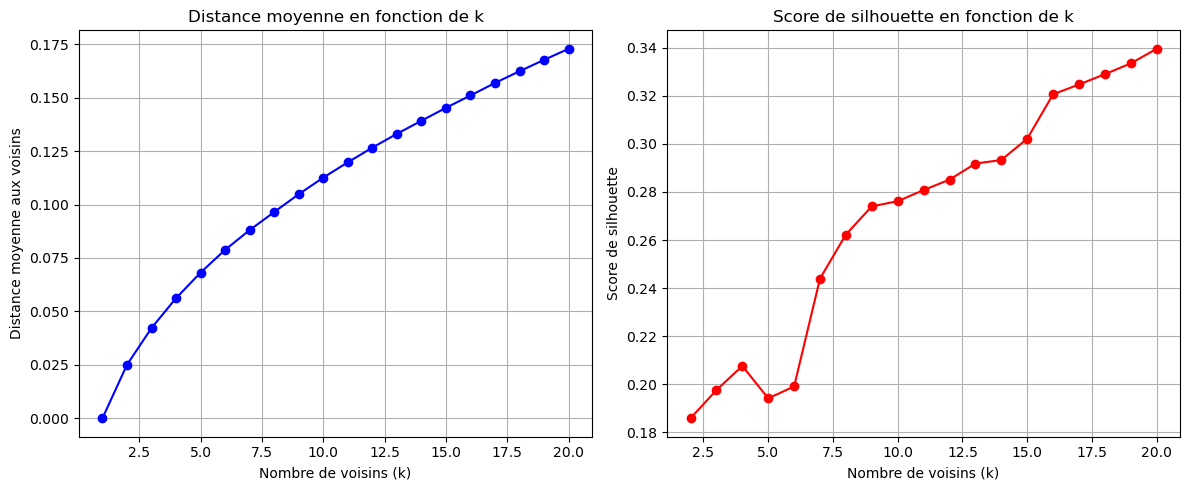

In [22]:
# Définition de la plage de k à tester
k_range = range(1, 21)  # Test des valeurs de k de 1 à 20

# Évaluation des différentes valeurs de k
avg_distances, silhouette_scores = evaluate_k(X_encoded, k_range)

# Création d'une visualisation pour aider à choisir k
plt.figure(figsize=(12, 5))

# Premier graphique : Distance moyenne aux voisins
plt.subplot(1, 2, 1)
plt.plot(k_range, avg_distances, 'bo-')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Distance moyenne aux voisins')
plt.title('Distance moyenne en fonction de k')
plt.grid(True)

# Second graphique : Score de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores[1:], 'ro-')  # On commence à k=2
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette en fonction de k')
plt.grid(True)

plt.tight_layout()
plt.show()

Ici le k idéal semble être entre 7 

# 8.Grid Search => NON car il faut un y pour ça
modèle = KNN
Paramètres


*   n-neighbors
*   metric = euclidien, manhattan, chebyshev


Remarque : pas besoin de faire une validation croisée après le gridsearch car si on utilise le paramètre cv dans le gridsearch, la validation croisée est inclue



# 9. Déclaration et entrainement du modèle
Mettre les paramètres ayant le meilleur score lors du GridSearch

In [23]:
from sklearn.neighbors import NearestNeighbors

# Création et ajustement du modèle NearestNeighbors
model = NearestNeighbors(n_neighbors=7, metric='euclidean')
model.fit(X_encoded)





NearestNeighbors(metric='euclidean', n_neighbors=7)

In [24]:
import pickle

# Sauvegarder le modèle
with open('modele_films_NN.pkl', 'wb') as f:
    pickle.dump(model, f)

# créer un fichier mon_modele.pkl que vous pouvez télécharger et mettre à l'endroit que vous voulez
# fichier réutilisable ailleurs

# vous importez vos fichiers csv pour vos données
# vous pouvez importer maintenant le fichier pkl pour votre modèle déjà entrainé

#ça vous pouvez le faire sur votre notebook

# 10. Récupération du titre de la cible

Question comment fait-on avec les doublons. Des films différents peuvent avoir le même titre

# 11. Recherche des films similaires à une cible

Fonction de Jonathan : Encodage des données à prédire => ligne du film

Il faut utiliser un id du film ex id_tmdb

In [25]:
df_a_predire = films[films['id_tmdb'] == 669666]
df_a_predire = df_a_predire[[ 'popularity', 'vote_average', 'genre_Drama', 'genre_Horror',
       'genre_Thriller', 'genre_Crime', 'genre_Animation', 'genre_Mystery',
       'genre_Family', 'genre_Western', 'genre_Adventure', 'genre_Action',
       'genre_Fantasy', 'genre_Comedy', 'genre_Music', 'genre_Romance',
       'genre_War', 'genre_Documentary', 'genre_History',
       'genre_Science Fiction']]

In [26]:
def encodage_predict(df_a_predire):
  X_num = df_a_predire[['popularity','vote_average']]
  X_cat = df_a_predire[['genre_Drama', 'genre_Horror',
       'genre_Thriller', 'genre_Crime', 'genre_Animation', 'genre_Mystery',
       'genre_Family', 'genre_Western', 'genre_Adventure', 'genre_Action',
       'genre_Fantasy', 'genre_Comedy', 'genre_Music', 'genre_Romance',
       'genre_War', 'genre_Documentary', 'genre_History',
       'genre_Science Fiction']]

  X_num_SN = pd.DataFrame(SN.transform(X_num), columns=X_num.columns).reset_index(drop=True)

  X_cat_dummies = pd.get_dummies(X_cat).reset_index(drop=True)
  X_encoded_predire = pd.concat([X_num_SN, X_cat_dummies], axis=1)

  # df_predict = X_encoded_predire

  # # DataFrame vide qui a les mêmes colonnes que X_encoded
  # df_final = pd.DataFrame(columns=X_encoded.columns)

  # # On veut que le DataFrame ait le même nombre de lignes que df_predict
  # df_final = df_final.reindex(index=df_predict.index)
  # # On met tous les NaN à False
  # df_final = df_final.fillna(False)

  # # On parcourt chaque colonne de df_predict
  # # Si la colonne est présente dans X_encoded alors on la garde
  # # Sinon, on la met à False
  # for column in df_predict.columns:
  #   if column in X_encoded.columns:
  #     df_final[column] = df_predict[column]

  return X_encoded_predire

Encodage du titre ex : Home

In [27]:
encodage_predict(df_a_predire)

,popularity,vote_average,genre_Drama,genre_Horror,genre_Thriller,genre_Crime,genre_Animation,genre_Mystery,genre_Family,genre_Western,genre_Adventure,genre_Action,genre_Fantasy,genre_Comedy,genre_Music,genre_Romance,genre_War,genre_Documentary,genre_History,genre_Science Fiction
0,0.001086,0.359616,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# 12. On affiche les films similaires

Fonction Jonathan pour trouver les similaires un peu adaptée

In [28]:
caracteristiques = ['popularity','vote_average', 'genre_Drama', 'genre_Horror',
       'genre_Thriller', 'genre_Crime', 'genre_Animation', 'genre_Mystery',
       'genre_Family', 'genre_Western', 'genre_Adventure', 'genre_Action',
       'genre_Fantasy', 'genre_Comedy', 'genre_Music', 'genre_Romance',
       'genre_War', 'genre_Documentary', 'genre_History',
       'genre_Science Fiction']

In [29]:
def films_similaires(tmdb):
  df_resultat = pd.DataFrame(columns=list(films.columns))
  # Vérifier si le film existe dans le dataset
  if tmdb not in films['id_tmdb'].values:
      return f"Le film {tmdb} n'est pas dans le dataset."

  # Récupérer les caractéristiques du film
  film_cible = films[films['id_tmdb'] == tmdb]

  caract_film = films[films['id_tmdb'] == tmdb][caracteristiques]

  caract_film_encoded = encodage_predict(caract_film)

  distances, indices = model.kneighbors(caract_film_encoded)
  return films.iloc[indices[0,1:]].reset_index(drop=True)

In [30]:

films_similaires(669666)


,adult,budget,genres_x,id_tmdb,imdb_id,original_language,original_title,overview,popularity,poster_path,...,genre_Romance,genre_Crime,genre_Action,genre_Comedy,genre_Science Fiction,genre_Documentary,genre_Animation,genre_Western,genre_War,genre_Horror
0,False,25000000,['Drama'],245692,tt2177827,fr,The Search,A woman who works for a non-governmental organ...,7.371,/ygXsQt3GniNMnrvOa5LrDP5tviY.jpg,...,False,False,False,False,False,False,False,False,False,False
1,False,0,['Drama'],633949,tt7265490,ar,دفاتر مايا,"Maia, a single mother, lives in Montreal with ...",3.797,/x0OjUpv5bGbzUVt9eyEb0sHAQpZ.jpg,...,False,False,False,False,False,False,False,False,False,False
2,False,0,['Drama'],660958,tt8132778,fr,La Nuit des rois,"A young man is sent to ""La Maca,"" a prison in ...",3.749,/lkY6Agn4sucxm2VHrPBk7pQah7m.jpg,...,False,False,False,False,False,False,False,False,False,False
3,False,0,['Drama'],2111,tt0291032,zh,巴尔扎克与小裁缝,"During the Cultural Revolution, two young men ...",3.667,/boIPnACAr2J29oLanoAuMjmQP8i.jpg,...,False,False,False,False,False,False,False,False,False,False
4,False,0,['Drama'],927594,tt18235306,ja,ラブライフ,"Taeko and her husband, Jiro, are living a peac...",3.612,/xcV80soWBrHS7RF67Cyk4brqi9B.jpg,...,False,False,False,False,False,False,False,False,False,False
5,False,2500000,['Drama'],41123,tt1405809,fr,Lourdes,Christine is a wheelchair-using woman with sev...,2.767,/aYgEnhmeajrz4UXDV9m4wwqtGFG.jpg,...,False,False,False,False,False,False,False,False,False,False
